# Forecasting Electricity Price in the Spain Using Supervised Learning 
### Team: Minho Kang, Lonny Chen, Johannes Müller, Daniyar Imanaliev
- GitHub repostiory: [MDS_ML_Project](https://github.com/MDS-Mountain-Club/MDS_ML_Project/tree/main)

# 1. Background

**The Spain Energy Price Prediction Project** aims to predict energy prices in Spain using a combination of historical energy generation data and weather forecast data.

## 1 - 1. Data

The data utilized for this project originates from the Kaggle dataset ["Hourly energy generation and weather in Spain"](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather), which includes hourly observations from 2015 to 2018. This dataset integrates energy generation data from the ENTSO-E platform with weather data for five major cities (Bilbao, Barcelona, Madrid, Valencia, and Sevilla) obtained from the Open Weather API. 

### Unit of analyses

Each row is a timestamped hourly observation that contains information about the different
sources of electricity supply in Spain joined with weather data from 5 different big cities
(Bilbao, Barcelona, Madrid, Valencia, Sevilla). The dataset spans hourly from 2015 to 2018,
so we have 35,064 observations \$=([4x365+1]*24)$ in total.

### Target variable

The goal is to develop predictive models that can accurately forecast energy prices in Spain.  Our dependent variable is the actual hourly energy prices ⁠ price actual ⁠ variable. 
Predictive models will use features such as past weather conditions, historical energy generation values, and time-specific data including prices for previous time hour periods (-1, -2, -3 hourly prices).


### Choosing a target for prediction

Our initial project goal was to predict renewable energy generation (solar or wind) for the next 3 hours. 
However, after exploratory data analyses we decided to switch our focus to price prediction, since ⁠ generation solar ⁠ variable looks like an exponential distribution with many values near zero, and ⁠ generation wind ⁠ is a substantially skewed normal curve towards lower values, with high outliers. Meanwhile actual energy prices ⁠ price actual ⁠ has the most "normal looking" distribution with the lowest absolute skew and lowest "coefficient of variation" (std divided by mean). 

## 1 - 2. Models 

We have built the following models:

- Linear Regressions (Ordinary Least Squares, Ridge, Lasso)
- Polynomial Regression (Lasso)
- Kernel Ridge RBF
- ⁠KNN
- Tree Models (Random Forest and XGBoost)
- RNN
- Timeseries Model (SARIMAX)

## 1 - 3. Policy implications

Predicting energy prices for the next hour using machine learning models significantly enhances decision-making in public policy, in particular for support environmental goals by promoting emission reduction and sustainability programs.

# 2. Exploratory Data Analysis

In [135]:
import xgboost as xgb
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

## 2 - 0. Data preparation

The data preparation tasks were done in the following two files in our GitHub repository:
1. [01_data_clean_join.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/01_data_clean_join.ipynb)
2. [02_data_outliers.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/02_data_outliers.ipynb)

In [136]:
df = pd.read_csv('Data/df_clean.csv', index_col='time', parse_dates=['time'])

## 2 - 1. Target variable distributions 

More details of our Exploratory Data Analysis (EDA) can be found here:
- [03_data_explore.ipynb](https://github.com/MDS-Mountain-Club/MDS_ML_Project/blob/main/03_data_explore.ipynb)

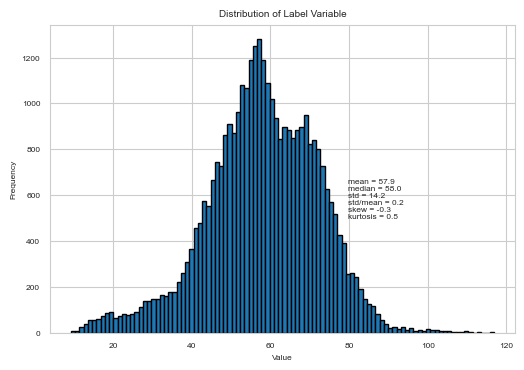

In [137]:
y_col = 'price actual'
y_price = df[y_col]
plt.figure(figsize=(6, 4))
plt.hist(y_price, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Label Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
hist_text(plt, 75, 500, y_price, 1, 'medium')
plt.show()

**Analysis:** 
- `'price actual'` is the "normal looking" distribution which may help performace of linear regression and "some" machine learning algorithms

## 2 - 2. Feature variables (weather) distributions 

Interesting weather features to take a closer look at:
- temperature, pressure, humidity variations across five cities

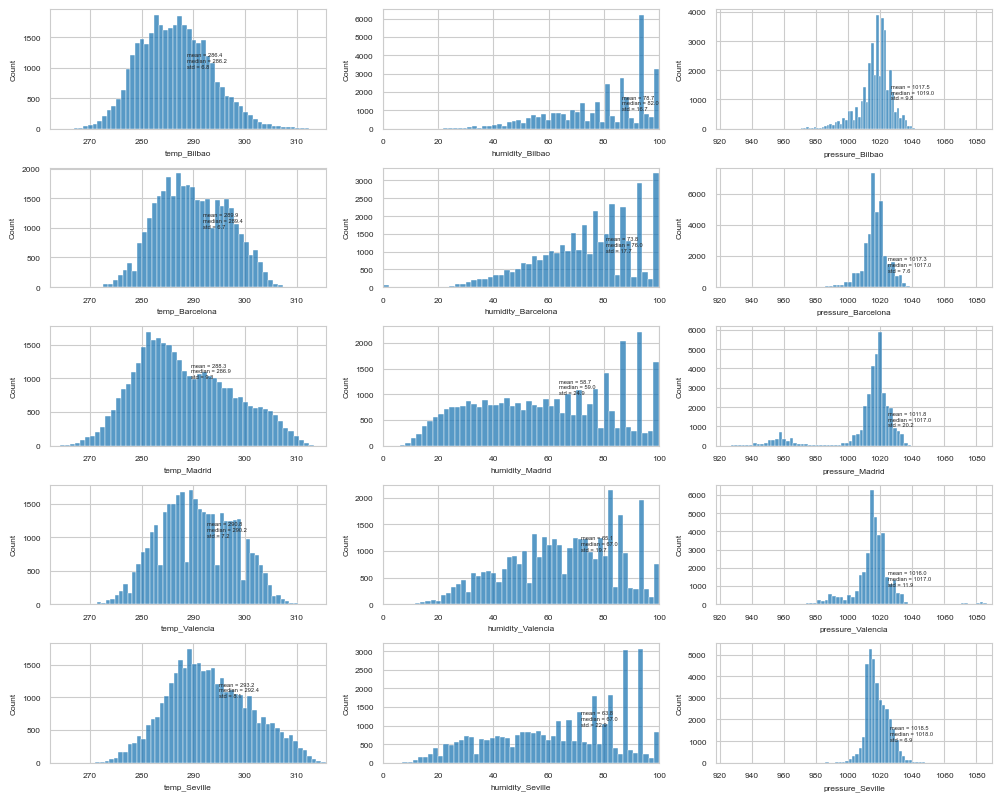

In [138]:
# Setup, order by North to South of Spain
weather_cols = [[col for col in df.columns if keyword in col] for keyword in ['temp', 'humidity', 'pressure']]
for i, _ in enumerate(weather_cols):
    weather_cols[i][0], weather_cols[i][1], weather_cols[i][2], weather_cols[i][3], weather_cols[i][4] = weather_cols[i][1], weather_cols[i][0], weather_cols[i][2], weather_cols[i][4], weather_cols[i][3]

# Get limits for consistent axes
col_mins = [min(min(df[col]) for col in cols) for cols in weather_cols]
col_maxs = [max(max(df[col]) for col in cols) for cols in weather_cols]

# Plots and annotate text
fig, axes = plt.subplots(5, 3, figsize=(10, 8))
for i, x_var in enumerate(weather_cols):
    for j, city in enumerate(x_var):
        sns.histplot(data=df, x=city, bins=50, ax=axes[j][i])
        axes[j][i].set_xlim(left=col_mins[i], right=col_maxs[i])
        hist_text(axes[j][i], np.percentile(df[city], 50), 1000, df[city], 1, 'x-small', False)  
    
plt.tight_layout()
plt.show()

**Observations:** 
- temperature curves do move to the right as we go south, Valencia exhibits some strange dips in the histogram
- humidity curve shapes vary more but it roughly varies inversely to temperature by city (e.g., low temp, high humidity)
- pressure varies little and seems similar in each city

## 2 - 3. Feature variables (generation) correlations

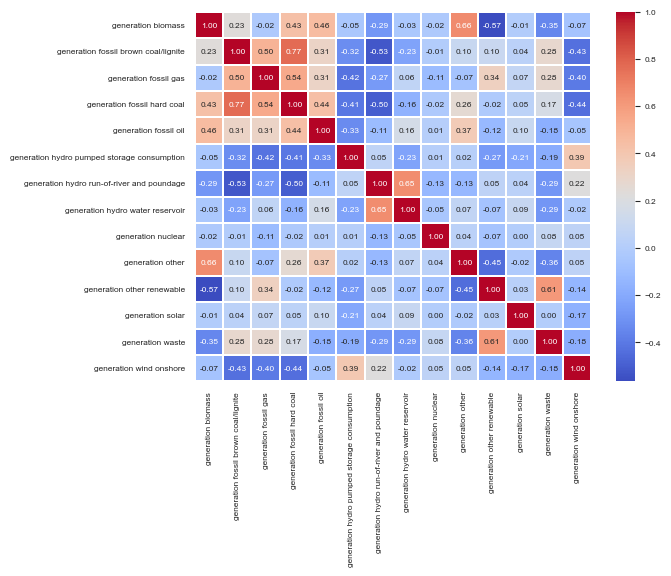

In [139]:
# Calculate correlations
df2 = df.copy()
generation_cols = [col for col in df2.columns if 'generation' in col]
df2_generation_corr = df2[generation_cols].corr(method='pearson')

# Plot heatmap
sns.heatmap(df2_generation_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.rcParams['font.size'] = 6

## 2 - 4. Target variable correlations

Last, we are looking at which features have high pearson correlation with y variable (`price actual`)

In [140]:
s_y_corr = df.corr(method='pearson')[y_col].sort_values(ascending=False)
s_y_corr[abs(s_y_corr) >= 0.3]

price actual                                   1.000000
price_prev_1                                   0.966790
price_prev_2                                   0.900490
price_prev_3                                   0.821566
price day ahead                                0.732167
generation fossil hard coal                    0.465953
generation fossil gas                          0.461567
total load forecast                            0.435918
total load actual                              0.435638
generation fossil brown coal/lignite           0.364006
generation hydro pumped storage consumption   -0.426251
Name: price actual, dtype: float64

**Observations:**
- There are no moderate or strong correlations with any of the weather variables!
- High correlations relate to previous or "day ahead" prices
- Moderate correlations relate to fossil generation (more expensive?) and total loads (market)

**Analysis**
- The metric here is Pearson "linear" correlation which may foreshadow poor predictabiltiy using linear regression models

## 2 - 5. Time-based EDA

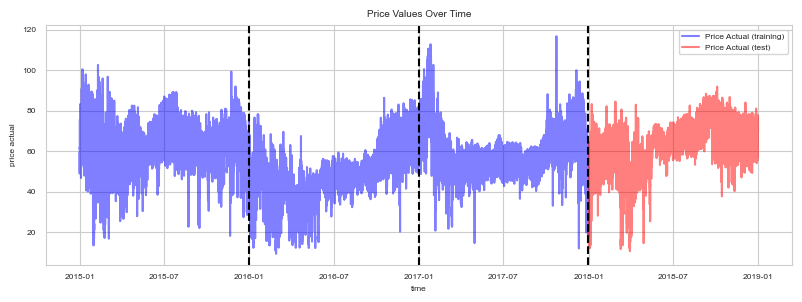

In [141]:
# Split train and test for plot
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
df_train, df_test = split_by_date(df, train_end_date)

# Create plot and lines for train/test and year boundaries
fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(data=df_train, x=df_train.index, y=y_col, label='Price Actual (training)', color='blue', alpha=0.5, ax=ax)
sns.lineplot(data=df_test, x=df_test.index, y=y_col, label='Price Actual (test)', color='red', alpha=0.5, ax=ax)
for year_end in ['2015-12-31', '2016-12-31', '2017-12-31']:
    plt.axvline(x=pd.to_datetime(year_end), color='black', linestyle='--')

ax.set_title('Price Values Over Time')
plt.tight_layout()
plt.show()

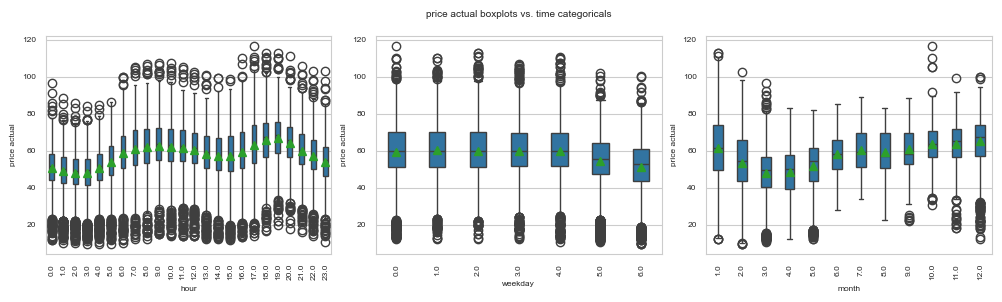

In [142]:
# Plot time-categorical boxplots to look for patterns
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, x_var in enumerate(['hour', 'weekday', 'month']):
    sns.boxplot(data=df, y=y_col, x=x_var, width=0.4, showmeans=True, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    if i == 1:
        axs[i].set_title(f'{y_col} boxplots vs. time categoricals\n')

plt.tight_layout()
plt.show()

# 3. Feature Engineering using XGBoost 

Here, as one part of feature engineering, we are going to do dimensional reduction using XGBoost. Specifically, we will use only top 10 important features based on the result of feature importance from XGBoost. 

## 3 - 1. Data Preprocessing 

In [143]:
X = df.drop(columns=['price actual'])
y_price = df['price actual']

In [144]:
# Split the data into train and test based on specific time '2017-12-31 23:00:00+00:00'
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')

# Here, we are using ourselves made function named "split_by_date"
X_train_scaled, X_test_scaled = split_by_date_and_standardize(X, train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)

## 3 - 2. Hyperparameter Tuning

In [145]:
xgb_reg = xgb.XGBRegressor(eval_metric = "rmse")
param_grid = {"max_depth": [4,5,6],
              "n_estimators" : [50, 100, 150],
              "learning_rate": [0.01, 0.015]
    
}
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(X_train_scaled, y_price_train)
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")


## 3 - 3. Find top 10 features

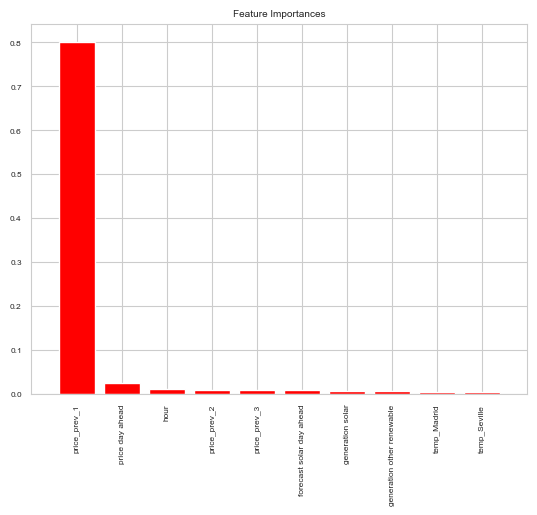

In [146]:
xgb_reg.fit(X_train_scaled, y_price_train)
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]
top_10_indices = indices[:10]
top_10_features = X_train_scaled.columns[top_10_indices]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(len(top_10_indices)), importances[top_10_indices], color='r', align='center')
plt.xticks(range(len(top_10_indices)), top_10_features, rotation=90)
plt.xlim([-1,len(top_10_indices)])
plt.show()

X_10 = df[top_10_features]

# 4. Model Evaluation

## 4 - 0. Introduction

### 4 - 0 - 1. Data prepration

* This data spans hourly from 2015 to 2018. We set until 2017 as train data and 2018 as test data. 
* We decide to standardize X data (dataset without y variable) for every model for improved model performance (neural networks, KNN, regularization), and balanced feature comparisons. However, using standardized y is depending on models because this doesn't consistently improve every model

In [147]:
train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')

# Standardize X variable always
X_train_scaled, X_test_scaled = split_by_date_and_standardize(X_10,train_end_date)

# Stadardize Y variable (This is depending on what model you use)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)
scaler_y = StandardScaler()
y_price_train_scaled = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
#y_price_test_scaled = scaler_y.fit_transform(y_price_test.values.reshape(-1, 1))
y_price_test_scaled = scaler_y.transform(y_price_test.values.reshape(-1, 1))

### 4 - 0 - 2. Dummy model

First, for comparing supervised learning models with a naive way, we make dummy regressor which predict a value as the mean of all train dataset

In [148]:
# Setup model evaluation dictionary, use with function `add_model_eval`
model_eval = dict()

# Baseline "dummy" prediction based on y-train mean
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_price_train)
y_pred_dummy = dummy_model.predict(X_test_scaled)

# Calculate Test RMSE etc.
print("RMSE of baseline dummy model for predicting price:", root_mean_squared_error(y_price_test, y_pred_dummy))
model_eval = add_model_eval(model_eval, 'Baseline dummy (y-train mean)', y_price_test, y_pred_dummy)

RMSE of baseline dummy model for predicting price: 14.282970288965133


## 4 - 1. Linear Regression

### 4 - 1 - 1. Ordinary Least Squares (OLS)

#### 4 - 1 - 1 - 1. Prediction and Evaluation

In [149]:
# Create and fit
ols_model = LinearRegression() 
ols_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate with metrics
y_pred_ols = ols_model.predict(X_test_scaled) 
print("RMSE of linear regression (OLS) for predicting price:", root_mean_squared_error(y_price_test, y_pred_ols))
model_eval = add_model_eval(model_eval, 'Linear Regression (OLS)', y_price_test, y_pred_ols)

RMSE of linear regression (OLS) for predicting price: 2.754342719669341


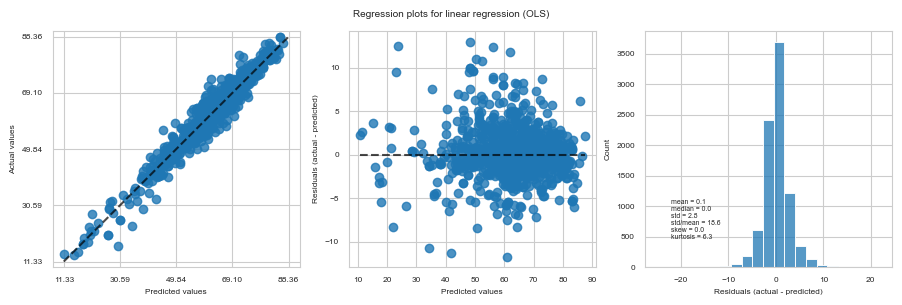

In [150]:
# Check plots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
model_eval_plot(y_price_test, y_pred_ols, fig, axes, 'Regression plots for linear regression (OLS)')

### 4 - 1 - 2. Ridge Regression

#### 4 - 1 - 2 - 1. Find Best Alpha

In [151]:
# Perform time-series cross-validation to find best alpha and apply 1SE rule
# Uses custom functions from functions.py
tscv = TimeSeriesSplit(n_splits=2)
ridge_alphas = np.logspace(-5, 5, 20)
ridge_scores = alpha_scores_cross_val(Ridge, X_train_scaled, y_price_train, tscv, ridge_alphas)
best_alpha_ridge, one_std_ridge = best_alpha_one_se_rule(ridge_scores)
print(f'The best ridge regression alpha is at: {best_alpha_ridge}')

The best ridge regression alpha is at: 20.6913808111479


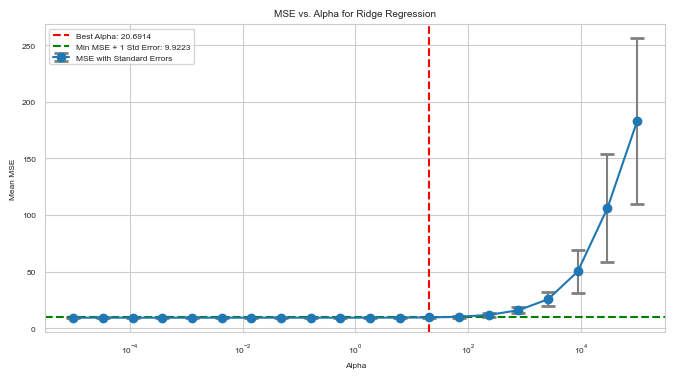

In [152]:
plot_mse_vs_parameter(ridge_scores['alphas'], ridge_scores['avg_mse'], ridge_scores['std_errors'], 
                      best_alpha_ridge, one_std_ridge, True, 'Alpha', 'Ridge Regression')

#### 4 - 1 - 2 - 2. Prediction and Evaluation

In [153]:
# Ridge model with best alpha: create and fit
best_ridge_model = Ridge(alpha=best_alpha_ridge)
best_ridge_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate
y_pred_ridge = best_ridge_model.predict(X_test_scaled)
print("RMSE of ridge regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_ridge))
model_eval = add_model_eval(model_eval, 'Ridge Regression', y_price_test, y_pred_ridge)

RMSE of ridge regression for predicting price: 2.756268583743204


### 4 - 1 - 3. Lasso Regression

#### 4 - 1 - 3 - 1. Find Best Alpha

In [154]:
# Perform time-series cross-validation to find best alpha and apply 1SE rule
# Uses custom functions from functions.py
tscv = TimeSeriesSplit(n_splits=2)
lasso_alphas = np.logspace(-5, 5, 20)
lasso_scores = alpha_scores_cross_val(Lasso, X_train_scaled, y_price_train, tscv, lasso_alphas)
best_alpha_lasso, one_std_lasso = best_alpha_one_se_rule(lasso_scores)
print(f'The best lasso regression alpha is at: {best_alpha_lasso}')

The best lasso regression alpha is at: 0.04832930238571752


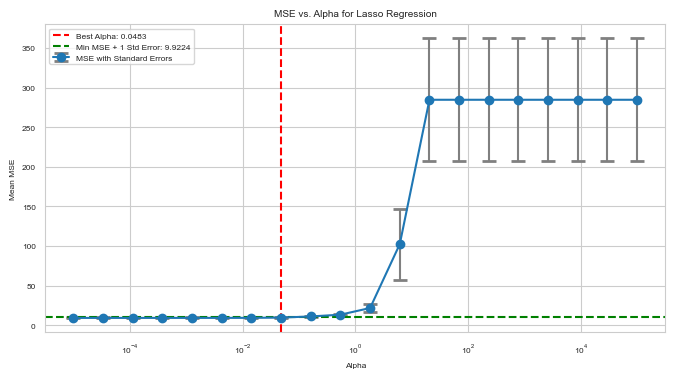

In [155]:
plot_mse_vs_parameter(lasso_scores['alphas'], lasso_scores['avg_mse'], lasso_scores['std_errors'],
                      best_alpha_lasso, one_std_lasso, True, 'Alpha', 'Lasso Regression')

#### 4 - 1 - 3 - 2. Prediction and Evaluation

In [156]:
# Lasso model with best alpha: create and fit
best_lasso_model = Lasso(alpha=best_alpha_lasso)
best_lasso_model.fit(X_train_scaled, y_price_train)

# Predict and evaluate
y_pred_lasso = best_lasso_model.predict(X_test_scaled)
print("RMSE of lasso regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_lasso))
model_eval = add_model_eval(model_eval, 'Lasso Regression', y_price_test, y_pred_lasso)

RMSE of lasso regression for predicting price: 2.775638429049703


## 4 - 2. Polynomial Regression

### 4 - 2 - 1. Find Best Degrees

In [157]:
# Loop setup
tscv = TimeSeriesSplit(n_splits=2)
lasso_alphas = np.logspace(-5, 5, 20)
lasso_degrees = np.arange(1, 6, 1) #1..5
poly_model_eval = dict()

# Loop through different degrees
for degree in lasso_degrees:
    
    # Data setup for THIS degree of polynomial terms
    X_10_poly = polynomial_terms(X_10, X_10.columns, degree)
    X_train_poly_scaled, X_test_poly_scaled = split_by_date_and_standardize(X_10_poly, train_end_date)
   
    # Find best alpha for THIS degree
    lasso_scores = alpha_scores_cross_val(Lasso, X_train_poly_scaled, y_price_train, tscv, lasso_alphas)
    df_lasso_scores = pd.DataFrame(lasso_scores)
    best_alpha_lasso, _ = best_alpha_one_se_rule(lasso_scores)
    best_std_error = df_lasso_scores.loc[df_lasso_scores['alphas'] == best_alpha_lasso, 'std_errors'].iloc[0]
    
    # Create, fit, and predict model with best alpha
    best_lasso_model = Lasso(alpha=best_alpha_lasso)
    best_lasso_model.fit(X_train_poly_scaled, y_price_train)
    y_pred_lasso = best_lasso_model.predict(X_test_poly_scaled)
    
    # Evaluate
    poly_model_eval = add_model_eval(poly_model_eval, degree, y_price_test, y_pred_lasso)
    poly_model_eval[degree]['best_alpha'] = best_alpha_lasso
    poly_model_eval[degree]['best_std_error'] = best_std_error

In [158]:
# Find best degrees
df_poly_model_eval = pd.DataFrame(poly_model_eval).T
best_mse = df_poly_model_eval['MSE'].min()
best_max_degree = int(df_poly_model_eval[df_poly_model_eval['MSE'] == best_mse].index[0])
print(f'The best polynomial degrees is: {best_max_degree}')

The best polynomial degrees is: 2


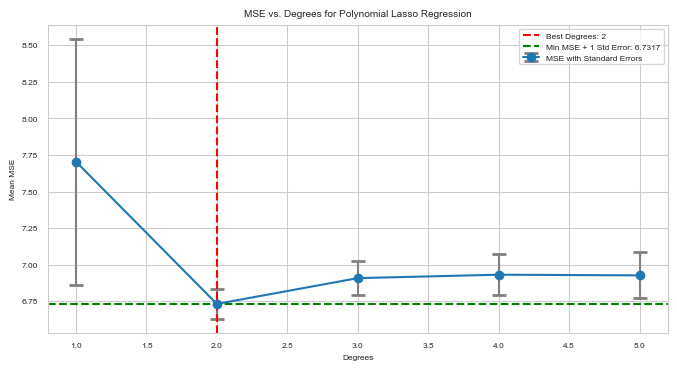

In [159]:
# Plot MSE vs. degrees
plot_mse_vs_parameter(df_poly_model_eval.index, df_poly_model_eval['MSE'], df_poly_model_eval['best_std_error'],
                   best_max_degree, best_mse, False, 'Degrees', 'Polynomial Lasso Regression')

### 4 - 2 - 2. Prediction and Evaluation

In [160]:
# Setup data
X_10_poly = polynomial_terms(X_10, X_10.columns, best_max_degree)
X_train_poly, X_test_poly = split_by_date(X_10_poly, train_end_date)
scaler_x_poly = StandardScaler()
X_train_poly_scaled = scaler_x_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_x_poly.transform(X_test_poly)

# Create, fit model
best_lasso_model = Lasso(alpha=df_poly_model_eval['best_alpha'].min())
best_lasso_model.fit(X_train_poly_scaled, y_price_train)

# Predict and evaluate
y_pred_poly_lasso = best_lasso_model.predict(X_test_poly_scaled)
print("RMSE of polynomial (lasso) regression for predicting price:", root_mean_squared_error(y_price_test, y_pred_poly_lasso))
model_eval = add_model_eval(model_eval, 'Polynomial Lasso Regression', y_price_test, y_pred_poly_lasso)

RMSE of polynomial (lasso) regression for predicting price: 2.594557100247647


## 4 - 3. Kernel Ridge RBF

Here, we apply peculiar unique method: Kernel Ridge with RBF. We skip the hyperparameter tuning, because it takes so long time.

In [161]:
# Create, fit model
knrl_rbf = KernelRidge(kernel = 'rbf')
knrl_rbf.fit(X_train_scaled, y_price_train)
y_price_pred_knrl_rbf = knrl_rbf.predict(X_test_scaled)
#RMSE
rmse_price_knrl_rbf = root_mean_squared_error(y_price_test, y_price_pred_knrl_rbf)
print("RMSE of Kernel Ridge with RBF for predicting price:", rmse_price_knrl_rbf)
model_eval = add_model_eval(model_eval, 'Kernel Ridge with RBF', y_price_test, y_price_pred_knrl_rbf)

RMSE of Kernel Ridge with RBF for predicting price: 3.704523562478479


## 4 - 4. KNN

### 4 - 4 - 1. Grid Search 

In [162]:
knn = KNeighborsRegressor()
# Set the candidates with 9,11,13,15,17
param_grid = {
    'n_neighbors': [9,11,13,15,17],
    'metric': ['euclidean', 'manhattan']
}
cv_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

### 4 - 4 - 2. Prediction and Evaluation

In [163]:
cv_knn.fit(X_train_scaled, y_price_train_scaled)

# Prediction 
y_price_pred_scaled_knn = cv_knn.predict(X_test_scaled)
y_price_pred_knn = scaler_y.inverse_transform(y_price_pred_scaled_knn.reshape(-1,1))

# RMSE
print("RMSE of KNN for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_knn))
model_eval = add_model_eval(model_eval, 'K-Nearest Neighbours (KNN)', y_price_test, y_price_pred_knn)

RMSE of KNN for predicting price: 3.9559091088602476


## 4 - 5. Tree models (Random Forest and XGboost)

### 4 - 5 - 1. Random Forest

In [164]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_price_train_scaled)
y_price_pred_scaled_rf = rf.predict(X_test_scaled)
y_price_pred_rf = scaler_y.inverse_transform(y_price_pred_scaled_rf.reshape(-1,1))
# RMSE
print("RMSE of Random Forest for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_rf))
model_eval = add_model_eval(model_eval, 'Random Forest', y_price_test, y_price_pred_rf)

RMSE of Random Forest for predicting price: 2.3975623343117913


### 4 - 5 - 2. XGboost

In [165]:
xgb_reg=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                        eval_metric = "rmse")
xgb_reg.fit(X_train_scaled, y_price_train_scaled)
y_price_pred_scaled_xgb = xgb_reg.predict(X_test_scaled)
y_price_pred_xgb = scaler_y.inverse_transform(y_price_pred_scaled_xgb.reshape(-1,1))

# RMSE
print("RMSE of XGB for predicting price:", root_mean_squared_error(y_price_test, y_price_pred_xgb))
model_eval = add_model_eval(model_eval, 'XGBoost', y_price_test, y_price_pred_xgb)

RMSE of XGB for predicting price: 2.798678066957824


## 4 - 6. RNN

### 4 - 6 - 1. Grid Search

In [166]:
X_train_scaled_rnn = X_train_scaled.to_numpy().reshape(-1,1,10)
X_test_scaled_rnn = X_test_scaled.to_numpy().reshape(-1,1,10)

y_price_train_scaled_rnn = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
y_price_test_scaled_rnn = scaler_y.transform(y_price_test.values.reshape(-1, 1))

def create_rnn_model(n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, input_shape=(1, n_features)))
    model.add(Dense(1))  # No activation function for regression
    model.compile(optimizer='adam', loss='mse')  # Using mean squared error for regression
    return model


n_features = X_train_scaled.shape[1]
n_neurons = [10, 20, 30]
param_grid = dict(model__n_neurons=n_neurons)

model_candi = KerasRegressor(model=create_rnn_model)
grid_rnn = GridSearchCV(model_candi, param_grid, cv=5, n_jobs=-1).fit(X_train_scaled_rnn,y_price_train_scaled_rnn)


822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4264


### 4 - 6 - 2. Prediction and Evaluation

In [167]:
# Prediction
best_rnn = grid_rnn.best_estimator_
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
best_rnn.fit(X_train_scaled_rnn, y_price_train_scaled_rnn, epochs=50, batch_size=20, validation_split=0.2,
                            verbose=0)
y_price_pred_scaled_rnn = best_rnn.predict(X_test_scaled_rnn).reshape(-1,1)
y_price_pred_rnn = scaler_y.inverse_transform(y_price_pred_scaled_rnn)
rmse_price_rnn = root_mean_squared_error(y_price_test, y_price_pred_rnn)
print("RMSE for predicting price:", rmse_price_rnn)
model_eval = add_model_eval(model_eval, 'RNN', y_price_test, y_price_pred_rnn)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE for predicting price: 2.572088175704799


### 

## 4 - 7. Time Series Model

From various time-series models, we utilyzed SARIMAX model (The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors). SARIMAX is a time series forecasting technique that extends the traditional ARIMA model to account for seasonality and external factors. SARIMAX model is extension of ARIMA model and part of auto regressive time series models

SARIMAX model is suitable for energy price prediction since during exploratory data analysis we identified that price data has a strong seasonal effect, as well as our dataset has other variables which can serve as Exogenous Regressors for SARIMAX model

### 4 - 7 - 1 Building function for SARIMAX

In [168]:
def sarimax_model_selection(y_train, X_train, y_test, X_test, p, d, q, P, D, Q, s):
    """
    Fits a SARIMAX model with the given parameters and returns the RMSE on the test set.

    Parameters:
    - y_train: training target series.
    - X_train: training exogenous variables (if any).
    - y_test: testing target series.
    - X_test: testing exogenous variables (if any).
    - p: AR order for non-seasonal model.
    - d: Differencing order for non-seasonal model.
    - q: MA order for non-seasonal model.
    - P: AR order for seasonal model.
    - D: Differencing order for seasonal model.
    - Q: MA order for seasonal model.
    - s: Number of observations per season (seasonal periodicity).

    Returns:
    - rmse: Root Mean Square Error of the model's forecast on the test set.
    - results: Fitted SARIMAX model object containing detailed diagnostic information about the model.
    - forecast: Forecast object containing information like predicted values, confidence intervals, etc.,
    for the test set.
    - mean_forecast: Array of predicted mean values from the forecast, which can be directly 
    compared to y_test for evaluation.

    """
    model = SARIMAX(y_train,
                    exog=X_train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=len(y_test), exog=X_test)
    mean_forecast = forecast.predicted_mean

    rmse = mean_squared_error(y_test, mean_forecast, squared=False)
    return rmse, results, forecast, mean_forecast

### 4 - 7 - 2. Tuning the SARIMAX model for the best parameters

Let's start from parameters p=1, d=0, q=1, P=1, D=0, Q=1, based on ASF and PASF plots (please refer to ARIMA folder in Github)\
Unfortunately, due to limitation of computational power, grid search or cross validation is not possible, however, we can identify parameters by hand. Here, for simplicity, we just showed the result of the best parameters.

In [169]:
#p=1, d=0, q=1, P=1, D=0, Q=1
rmse_price_sarimax, results_1, forecast_1, mean_forecast_1 = sarimax_model_selection(y_price_train, 
                                                                         X_train_scaled,
                                                                         y_price_test,
                                                                         X_test_scaled,
                                                                         1, 0, 1, 1, 0, 1, 12)
print("RMSE of SARIMAX for predicting price:", rmse_price_sarimax)

RMSE of SARIMAX for predicting price: 2.852698822304837


# 5. The final model

Here we do a final comparison of all trained and evaluated models based on the Root Mean Square Error (RMSE) for predicting the test data.

In [170]:
# Display final comparison table as a DataFrame
model_summary = pd.DataFrame(model_eval).T.sort_values('RMSE')
model_summary

,MSE,RMSE,R2,MAE,MAPE
Random Forest,5.748305,2.397562,0.961435,1.683274,0.029435
RNN,6.615638,2.572088,0.955616,1.849357,0.032096
Polynomial Lasso Regression,6.731727,2.594557,0.954837,1.813470,0.032168
Linear Regression (OLS),7.586404,2.754343,0.949103,1.884506,0.033580
Ridge Regression,7.597017,2.756269,0.949032,1.883995,0.033580
Lasso Regression,7.704169,2.775638,0.948313,1.887801,0.033689
XGBoost,7.832599,2.798678,0.947452,2.053545,0.037722
Kernel Ridge with RBF,13.723495,3.704524,0.907930,2.576415,0.042240
K-Nearest Neighbours (KNN),15.649217,3.955909,0.895011,2.871447,0.049699
Baseline dummy (y-train mean),204.003240,14.282970,-0.368643,11.953448,0.212781


In [171]:
lowest_rmse_model = model_summary['RMSE'].idxmin()
lowest_rmse = model_summary.loc[lowest_rmse_model,'RMSE']

print(f"The best model is {lowest_rmse_model} and its RMSE is {lowest_rmse}")

The best model is Random Forest and its RMSE is 2.3975623343117913


## 5 - 1. Prediction and residuals analysis

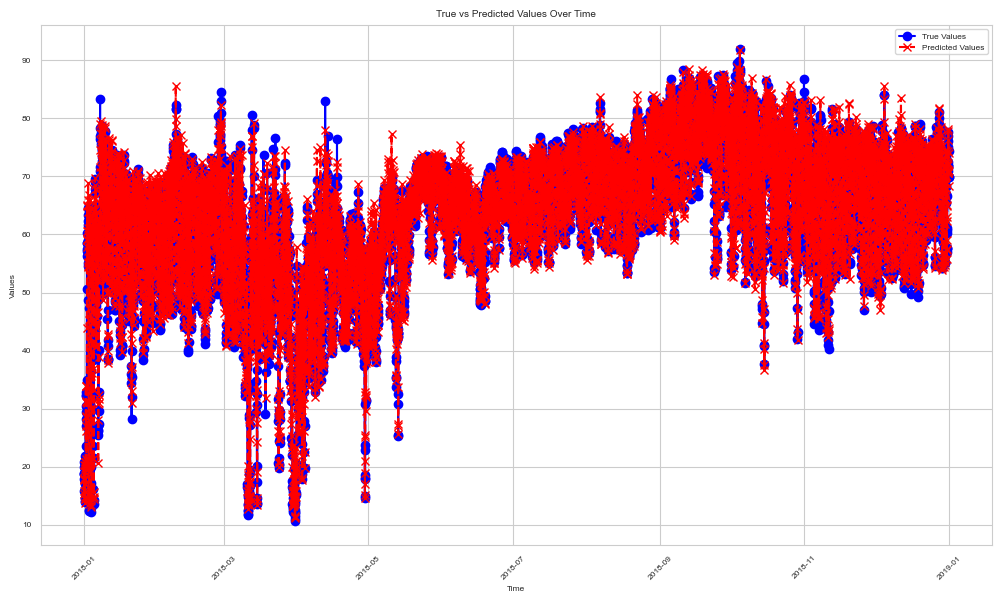

In [172]:
# Plot time-series true vs. prediction of best model
plot_true_pred(X_test_scaled, y_price_pred_rf, y_price_test)

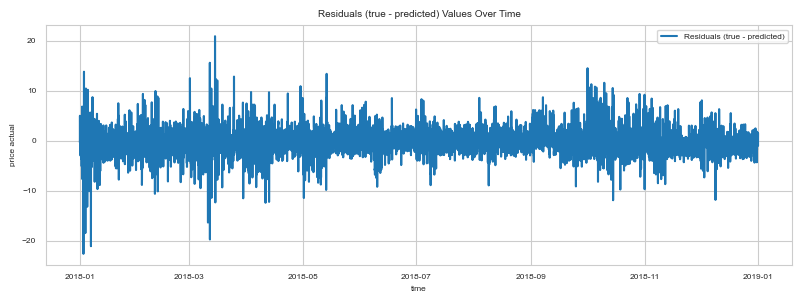

In [173]:
# Setup residuals data
y_residual = y_price_test - y_price_pred_rf.reshape(-1)

# Time-series line plot
fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(x=y_price_test.index, y=y_residual, label='Residuals (true - predicted)', ax=ax)

ax.set_title('Residuals (true - predicted) Values Over Time')
plt.tight_layout()
plt.show()

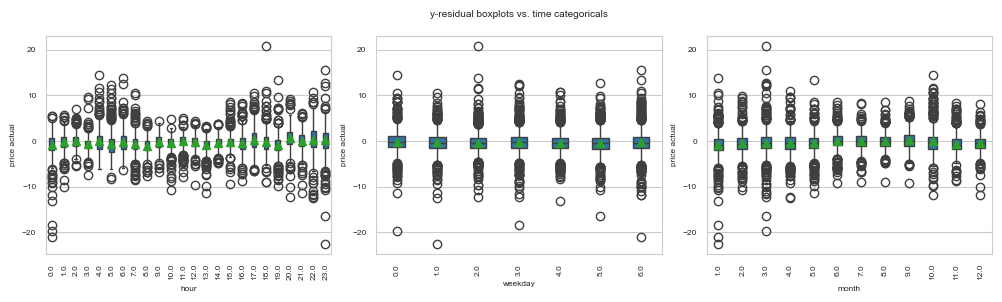

In [174]:
# Plot time-categorical boxplots to look for patterns
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, x_var in enumerate(['hour', 'weekday', 'month']):
    sns.boxplot(data=df, y=y_residual, x=x_var, width=0.4, showmeans=True, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    if i == 1:
        axs[i].set_title('y-residual boxplots vs. time categoricals\n')

plt.tight_layout()
plt.show()

# 6. Discussion and Conclusion